<a href="https://colab.research.google.com/github/harshavardhangadila/Transformers-and-NLP/blob/main/Keras%20NLP%20Tasks/Build_%26_Train_Transformer_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 100, 32)        │        67,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 100, 32)        │        12,736 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,638 (314.99 KB)

 Trainable params: 80,638 (314.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.5185 - loss: 0.7264 - val_accuracy: 0.5300 - val_loss: 0.6926
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5471 - loss: 0.6838 - val_accuracy: 0.4800 - val_loss: 0.6932
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6368 - loss: 0.6494 - val_accuracy: 0.4650 - val_loss: 0.7701
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7575 - loss: 0.5305 - val_accuracy: 0.4700 - val_loss: 0.8178
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9136 - loss: 0.2688 - val_accuracy: 0.5000 - val_loss: 1.3999


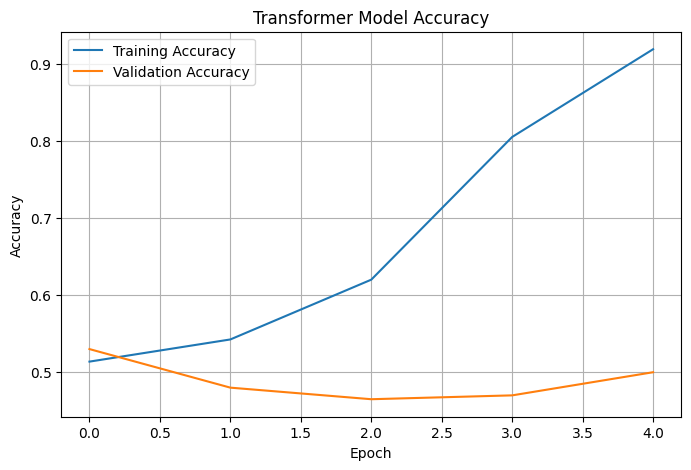

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
Predicted class: 0 | Probabilities: [0.63334024 0.36665976]


In [5]:
# Step 2: Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Create synthetic tokenized dataset
vocab_size = 2000  # Vocabulary size
sequence_length = 100  # Number of tokens per input sequence
num_classes = 2  # Number of output classes (binary classification)
samples = 1000  # Number of samples

# Generate random input sequences and labels
X = np.random.randint(0, vocab_size, size=(samples, sequence_length))
y = np.random.randint(0, num_classes, size=(samples,))

# Split into training and validation sets
X_train, y_train = X[:800], y[:800]
X_val, y_val = X[800:], y[800:]

# Step 4: Define Token and Position Embedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)  # Token embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)  # Positional embedding

    def call(self, x):
        maxlen = tf.shape(x)[-1]  # Get sequence length
        positions = tf.range(start=0, limit=maxlen, delta=1)  # Position indices
        embedded_tokens = self.token_emb(x)  # Token embeddings
        embedded_positions = self.pos_emb(positions)  # Position embeddings
        return embedded_tokens + embedded_positions  # Combine embeddings

# Step 5: Define Transformer Encoder block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)  # Multi-head attention
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),  # Feedforward layer 1
            layers.Dense(embed_dim),  # Feedforward layer 2
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)  # Normalization 1
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)  # Normalization 2
        self.dropout1 = layers.Dropout(rate)  # Dropout after attention
        self.dropout2 = layers.Dropout(rate)  # Dropout after feedforward

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)  # Apply dropout
        out1 = self.layernorm1(inputs + attn_output)  # Add & norm

        ffn_output = self.ffn(out1)  # Feedforward network
        ffn_output = self.dropout2(ffn_output, training=training)  # Apply dropout
        return self.layernorm2(out1 + ffn_output)  # Add & norm

# Step 6: Build Transformer model
embed_dim = 32  # Embedding dimension
num_heads = 2  # Number of attention heads
ff_dim = 64  # Feedforward layer size

inputs = layers.Input(shape=(sequence_length,))  # Input layer
x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)(inputs)  # Embedding
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)  # Transformer encoder

x = layers.GlobalAveragePooling1D()(x)  # Global pooling
x = layers.Dropout(0.1)(x)  # Dropout
x = layers.Dense(20, activation="relu")(x)  # Dense layer
x = layers.Dropout(0.1)(x)  # Dropout
outputs = layers.Dense(num_classes, activation="softmax")(x)  # Output layer

model = keras.Model(inputs=inputs, outputs=outputs)  # Build model
model.summary()  # Print model summary

# Step 7: Compile and train model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5
)

# Step 8: Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Transformer Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Run inference on a custom input
sample_input = np.random.randint(0, vocab_size, size=(1, sequence_length))  # Generate random test input
pred = model.predict(sample_input)  # Predict
predicted_class = np.argmax(pred, axis=1)[0]  # Get predicted class

# Print result
print(f"Predicted class: {predicted_class} | Probabilities: {pred[0]}")

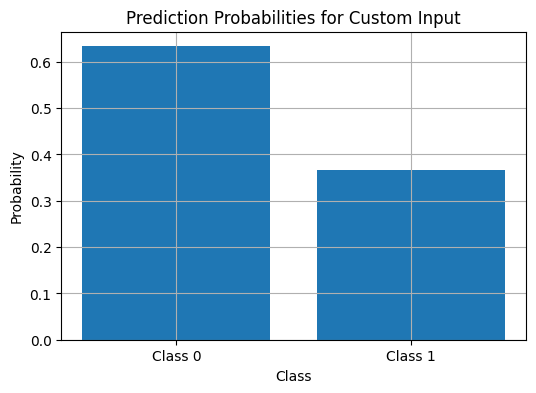

In [6]:
# Step 10: Visualize prediction probabilities as a bar chart
plt.figure(figsize=(6, 4))
plt.bar(range(num_classes), pred[0], tick_label=[f"Class {i}" for i in range(num_classes)])
plt.title("Prediction Probabilities for Custom Input")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


In [7]:
# Step 11: Visualize learned embeddings with t-SNE (optional, for small datasets)
from sklearn.manifold import TSNE

# Get representations from the penultimate dense layer
intermediate_model = keras.Model(inputs=model.input, outputs=model.layers[-3].output)
val_representations = intermediate_model.predict(X_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [8]:
# Reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
val_tsne = tsne.fit_transform(val_representations)


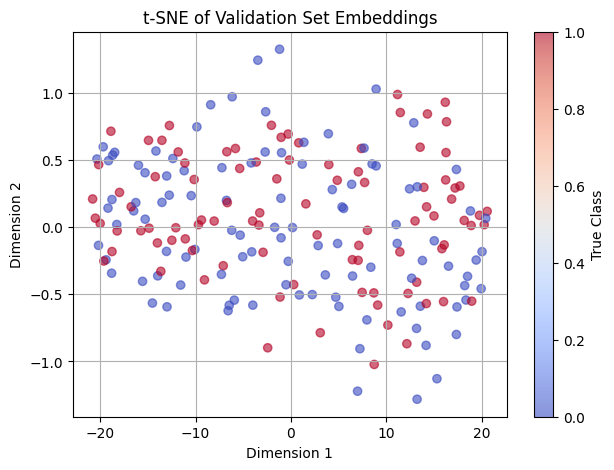

In [9]:
# Plot 2D t-SNE
plt.figure(figsize=(7, 5))
plt.scatter(val_tsne[:, 0], val_tsne[:, 1], c=y_val, cmap="coolwarm", alpha=0.6)
plt.colorbar(label="True Class")
plt.title("t-SNE of Validation Set Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

In [10]:
# Show top-k predicted classes
k = min(5, num_classes)
top_k_indices = np.argsort(pred[0])[::-1][:k]
print("Top-k Predicted Classes:")
for i in top_k_indices:
    print(f"Class {i}: Probability = {pred[0][i]:.4f}")

Top-k Predicted Classes:
Class 0: Probability = 0.6333
Class 1: Probability = 0.3667


In [11]:
# Compute confidence (max prob) and entropy (uncertainty)
confidence = np.max(pred[0])
entropy = -np.sum(pred[0] * np.log(pred[0] + 1e-10))  # Add epsilon for numerical stability

print(f"Prediction Confidence: {confidence:.4f}")
print(f"Prediction Entropy: {entropy:.4f}")

Prediction Confidence: 0.6333
Prediction Entropy: 0.6572


In [14]:
# Simulated example 1: mostly negative tokens
sample_neg = np.array([[12, 34, 45, 56, 67, 78, 89, 21, 3, 9] + [0]*(sequence_length - 10)])

# Simulated example 2: mostly positive tokens
sample_pos = np.array([[1990, 1985, 1975, 1960, 1950, 1945, 1930, 1920, 1905, 1910] + [0]*(sequence_length - 10)])

# Simulated example 3: mixed sentiment
sample_mix = np.array([[12, 1990, 34, 1985, 45, 1975, 56, 1960, 67, 1950] + [0]*(sequence_length - 10)])

# Stack them together for batch prediction
test_samples = np.vstack([sample_neg, sample_pos, sample_mix])

In [15]:
#  Run Inference on All Examples
preds = model.predict(test_samples)
predicted_classes = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


In [16]:
labels = ["Negative", "Positive"] if num_classes == 2 else [f"Class {i}" for i in range(num_classes)]
example_names = ["Sample Negative", "Sample Positive", "Sample Mixed"]

for i in range(len(test_samples)):
    print(f"{example_names[i]} => Predicted class: {predicted_classes[i]} ({labels[predicted_classes[i]]}) | Probabilities: {preds[i]}")

Sample Negative => Predicted class: 1 (Positive) | Probabilities: [3.2244297e-04 9.9967754e-01]
Sample Positive => Predicted class: 1 (Positive) | Probabilities: [3.647663e-04 9.996352e-01]
Sample Mixed => Predicted class: 1 (Positive) | Probabilities: [3.5546164e-04 9.9964452e-01]
